In [1017]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.offline as pyo
import folium
%matplotlib inline
import datetime

In [1018]:
df = pd.read_csv('haverhill-request.csv', encoding = "ISO-8859–1")

In [1019]:
df.columns

Index(['Request ID', 'Create Date', 'Master Request', 'Has Links', 'Status',
       'Status Code', 'Last Action', 'Last Change', 'Close Date',
       'Work Order Created', 'Request Type ID', 'Request Type',
       'Request Type Private', 'Request Type Info', 'Department ID',
       'Department', 'Address Number', 'Street ID', 'Street', 'Address',
       'Complete Address', 'City ID', 'City', 'Cross Street ID',
       'Cross Street', 'District ID', 'District', 'Escalations', 'Priority',
       'Longitude', 'Latitude', 'Origin ID', 'Origin'],
      dtype='object')

In [1020]:
keep = [ 'Create Date', 'Status', 'Close Date', 'Request Type', 'Complete Address', 'Longitude', 'Latitude','Origin']

In [1021]:
df = df[keep]

In [1022]:
df['Request Type'].value_counts().nlargest(6).sum()/df.shape[0]

0.7172566371681416

In [1023]:
df['Request Type'].value_counts().nlargest(14).index

Index(['A - Information Other', 'A - Transfer Inspections',
       'A - Transfer Other', 'A - Transfer Treasurer',
       'A - Information Treasurer ', 'A - Transfer Assessor',
       'Highway - Pothole', 'A - Information Assessor',
       'Snow Removal Issues - Sanding Request',
       'Tree Issues - City Owned Tree Issue',
       'Snow Removal Issues - Replow Request', 'TRASH - Missed Pick Up',
       'Traffic/Street Lights - Street Light Repair',
       'A - Information Inspections'],
      dtype='object')

In [1024]:
# Removing 'Request Types that don't give enough information

df_filtered = df.reset_index()
df_filtered = df_filtered.set_index('Request Type',drop = True) #Setting index as Request Type
remove_rt = ['A - Information Other', 'A - Transfer Inspections','A - Transfer Other',
             'A - Transfer Treasurer','A - Information Treasurer ','A - Transfer Assessor',
            'A - Information Assessor','A - Information Inspections'] #removing index 

for val in remove_rt:    
    df_filtered = df_filtered.drop(val)
    
df_filtered = df_filtered.reset_index()    
df_filtered.head()

,Request Type,index,Create Date,Status,Close Date,Complete Address,Longitude,Latitude,Origin
0,Traffic/Street Lights - Street Light Repair - ...,0,2017-01-03 13:11:00,Closed,2017-01-03 14:05:00,"JUSTIN ST, Haverhill, MA",-71.105902,42.767552,Call Center
1,Snow Removal Issues - Sanding Request,10,2017-01-03 14:18:00,Closed,2017-01-03 18:08:00,"SOLITAIRE DR, Haverhill, MA",-71.073723,42.804261,Call Center
2,Traffic/Street Lights - Street Light Repair - ...,12,2017-01-03 14:27:00,Closed,2017-06-23 16:10:00,"LAKEVIEW AVE, Haverhill, MA",-71.083366,42.795998,Call Center
3,Poor Property Maintenance,13,2017-01-03 14:45:00,In Progress,NaN,"44 JACKSON ST, Haverhill, MA",-71.091456,42.773071,Call Center
4,Highway - Pothole,15,2017-01-03 14:51:00,Closed,2017-01-17 16:37:00,"114- 116 BOARDMAN ST, Haverhill, MA",-71.061722,42.774201,Call Center


# Exploratory Data Analysis

In [1025]:
df_filtered.isnull().sum()

Request Type           0
index                  0
Create Date            0
Status                 0
Close Date          2416
Complete Address       0
Longitude              0
Latitude               0
Origin                 0
dtype: int64

In [1026]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17645 entries, 0 to 17644
Data columns (total 9 columns):
Request Type        17645 non-null object
index               17645 non-null int64
Create Date         17645 non-null object
Status              17645 non-null object
Close Date          15229 non-null object
Complete Address    17645 non-null object
Longitude           17645 non-null float64
Latitude            17645 non-null float64
Origin              17645 non-null object
dtypes: float64(2), int64(1), object(6)
memory usage: 1.2+ MB


In [1108]:
# Convert to datetime
df_filtered['Create Date'] = pd.to_datetime(df_filtered['Create Date'])
df_filtered['Close Date'] = pd.to_datetime(df_filtered['Close Date'])
df_filtered['Days_to_close'] = df_filtered['Close Date'] - df_filtered['Create Date']
df_filtered['year'] = df_filtered['Create Date'].apply(lambda x: int(x.year))
df_filtered['month'] = df_filtered['Create Date'].apply(lambda x: x.month)

In [1109]:
df_filtered.head(1)

,Request Type,index,Create Date,Status,Close Date,Complete Address,Longitude,Latitude,Origin,Days_to_close,year,month
0,Traffic/Street Lights - Street Light Repair - ...,0,2017-01-03 13:11:00,Closed,2017-01-03 14:05:00,"JUSTIN ST, Haverhill, MA",-71.105902,42.767552,Call Center,00:54:00,2017,1


In [1110]:
df_filtered['Request Type'].value_counts().nlargest(5)

top5index = df_filtered['Request Type'].value_counts().nlargest(5).index


In [1111]:
df_filtered_top = df_filtered[df_filtered['Request Type'].isin(top5index)]

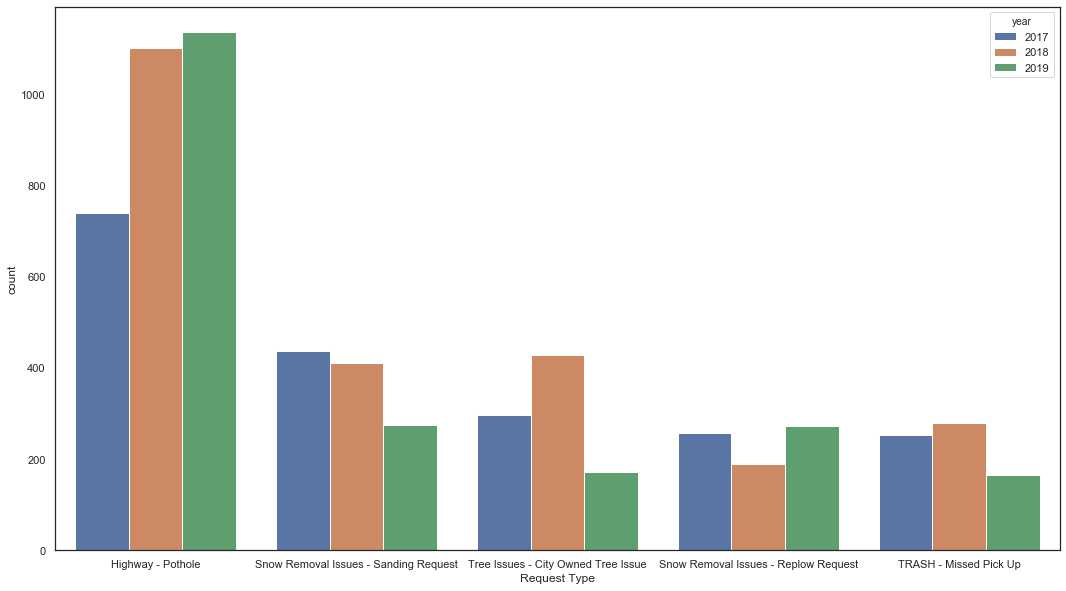

In [1130]:
# Top 5 problems , hue = year

figure ,axes = plt.subplots(1,1, figsize=(18, 10))

sns_plot = sns.countplot(x = 'Request Type',
           data = df_filtered_top,
           order = df_filtered_top['Request Type'].value_counts().index, hue = df_filtered_top['year'])

fig = sns_plot.get_figure()

fig.savefig("Top5_yearly.png")

In [1168]:
#Data frame for time analyses
df_by_time = df_filtered.sort_values('Days_to_close', ascending= False)

In [1169]:
df_by_time = df_by_time.dropna()

In [1170]:
df_by_time.head(6)

,Request Type,index,Create Date,Status,Close Date,Complete Address,Longitude,Latitude,Origin,Days_to_close,year,month
2296,Highway - Line Painting,8966,2017-06-09 19:48:00,Closed,2019-09-09 13:52:00,"9 VARNUM ST, Haverhill, MA",-71.094332,42.767815,Call Center,821 days 18:04:00,2017,6
861,Parks & Recreation,3244,2017-02-27 20:50:00,Closed,2019-05-08 14:05:00,"HILLDALE AVE, Haverhill, MA",-71.108745,42.794623,Call Center,799 days 17:15:00,2017,2
171,Graffiti - Private Property,959,2017-01-20 18:50:00,Closed,2019-03-21 17:53:00,"WHITE ST, Haverhill, MA",-71.079825,42.779773,Call Center,789 days 23:03:00,2017,1
1248,Highway - Sidewalk Request,4488,2017-03-17 16:17:00,Closed,2019-05-09 13:28:00,"PILLING ST, Haverhill, MA",-71.096105,42.773901,Call Center,782 days 21:11:00,2017,3
2767,Stormwater/Sewer - Catch Basin Cleaning,10941,2017-07-19 14:09:00,Closed,2019-08-26 10:30:00,"DAVIS ST, Haverhill, MA",-71.097590,42.768628,Call Center,767 days 20:21:00,2017,7
2361,Highway - Crosswalk,9282,2017-06-16 13:53:00,Closed,2019-07-23 13:41:00,"JORDAN ST, Haverhill, MA",-71.043490,42.766460,Call Center,766 days 23:48:00,2017,6


In [1171]:
df_by_time['Days_to_close'] = df_by_time['Days_to_close'].apply(lambda x: int(x.days))
grouped = df_by_time.groupby('Request Type').mean()

In [1172]:
top_5_2 = grouped.sort_values(by = 'Days_to_close',ascending = False).head(5)


In [1173]:
top_5_2

,index,Longitude,Latitude,Days_to_close,year,month
Request Type,,,,,,
Conservation/Wetlands,8905.75000,-71.061974,42.781838,505.750000,2017.000000,6.000000
Engineering - Sink Holes,30494.66087,-69.848789,42.031747,293.886957,2017.852174,6.478261
Highway - Line Painting,35320.55000,-71.099904,42.781526,272.850000,2017.900000,7.850000
Highway - Sidewalk Request,21890.62766,-68.056322,40.954956,261.308511,2017.457447,6.861702
Public Works Department,38774.00000,-47.401712,28.514263,249.666667,2018.333333,4.333333


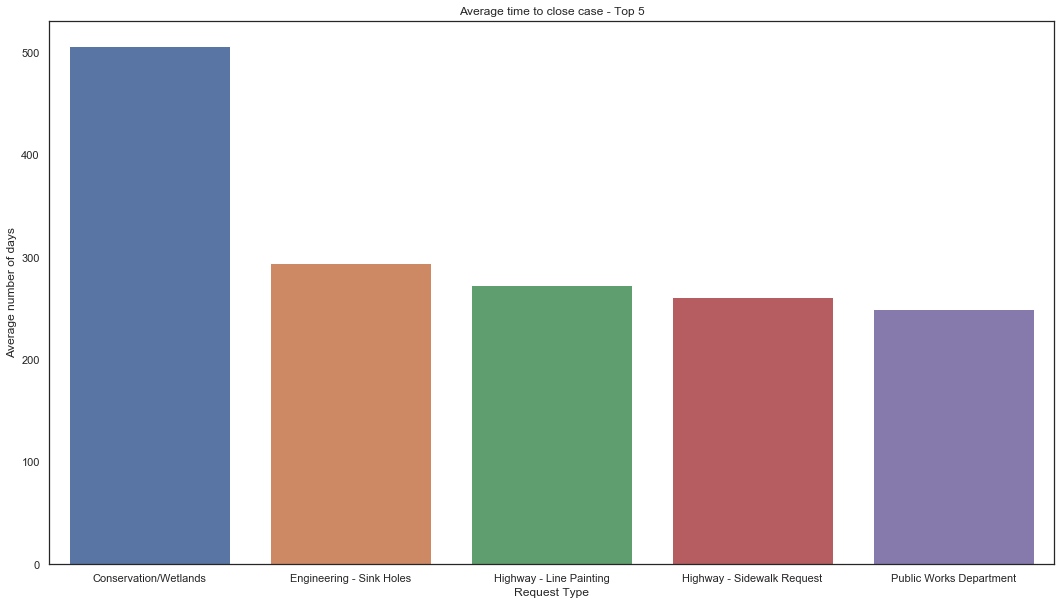

In [1174]:
# Top 5 problems , hue = year

figure ,axes = plt.subplots(1,1, figsize=(18, 10))

sns_plot = sns.barplot(x = top_5_2.index, y= top_5_2.Days_to_close)
plt.ylabel('Average number of days')
plt.title('Average time to close case - Top 5')

figure = sns_plot.get_figure()

figure.savefig("Days_to_close.png")


In [1010]:
df_by_time.head(1)

,Request Type,index,Create Date,Status,Close Date,Complete Address,Longitude,Latitude,Origin,Days_to_close,year,month
2510,Highway - Line Painting,8966,2017-06-09 19:48:00,Closed,2019-09-09 13:52:00,"9 VARNUM ST, Haverhill, MA",-71.094332,42.767815,Call Center,821,2017,6


In [1177]:
#df_col_month

In [276]:
df_col_month = df_by_time.groupby('year')['month'].value_counts(sort = False)

In [277]:
df_col_month = pd.DataFrame(df_col_month)

In [1167]:
# Add data
month = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
         'August', 'September', 'October', 'November', 'December']

#x=df_col_month['month'][2017].index, df_col_month['month'][2018].index


fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x = month, y=df_col_month['month'][2017].values, name='2017'
                         ))
fig.add_trace(go.Scatter(x=month, y=df_col_month['month'][2018].values, name = '2018'
                         ))
fig.add_trace(go.Scatter(x=month, y=df_col_month['month'][2019].values, name='2019'))
       


# Edit the layout
fig.update_layout(title='Trend in number of service requests - by year',
                   xaxis_title='Month',
                   yaxis_title='Cases Created ')

# Change the bar mode
fig.update_layout(barmode='stack')
#fig.update_xaxes(categoryorder='total descending')
fig.write_html('TypeOfRequest_Yearly.html', auto_open=True)
fig.show()



In [1152]:
featuresMap = ['Request Type', 'Longitude','Latitude','year','month']
df_map = df_filtered[featuresMap]
df_map.head()

,Request Type,Longitude,Latitude,year,month
0,Traffic/Street Lights - Street Light Repair - ...,-71.105902,42.767552,2017,1
1,Snow Removal Issues - Sanding Request,-71.073723,42.804261,2017,1
2,Traffic/Street Lights - Street Light Repair - ...,-71.083366,42.795998,2017,1
3,Poor Property Maintenance,-71.091456,42.773071,2017,1
4,Highway - Pothole,-71.061722,42.774201,2017,1


# Coreelation between weather, location and request type

In [1163]:
SF_COORDINATES = (42.7762, -71.0773)

# for speed purposes
MAX_RECORDS = 1000
  
# create empty map zoomed in on San Francisco
map_haverhill = folium.Map(location=SF_COORDINATES, zoom_start=12)
 
# add a marker for every record in the filtered data, use a clustered view
for row in map_group17[0:100].itertuples():
    folium.Marker(location=[float(row.Latitude), float(row.Longitude)], 
                  popup=df_map['Request Type']).add_to(map_haverhill)

In [1164]:
map_haverhill

In [1160]:
map_group = df_map[df_map['Request Type'] == 'Highway - Pothole'][['Latitude', 'Longitude', 'year','month']]
map_group17 = map_group[map_group.year == 2017].head(300)

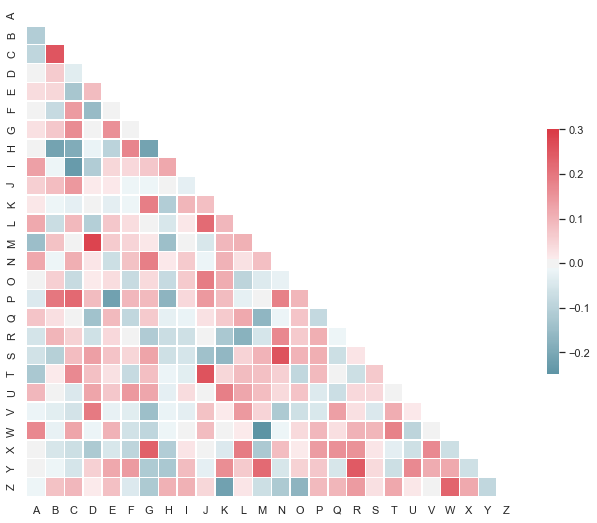

In [338]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [488]:
df_by_time.shape

(17391, 12)

In [487]:
df_filtered.shape

(19809, 10)

In [483]:
df_filtered["Request Type"].value_counts()

Highway - Pothole                        2976
A - Information Assessor                 1541
Snow Removal Issues - Sanding Request    1123
Tree Issues - City Owned Tree Issue       897
Snow Removal Issues - Replow Request      718
                                         ... 
Snow Removal Issues - Vehicle Damage        1
Failure to Display Permit/License           1
Traffic Light Camera                        1
Illegal Posting                             1
School Department                           1
Name: Request Type, Length: 159, dtype: int64

In [ ]:
# Add data
month = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
         'August', 'September', 'October', 'November', 'December']


fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=month, y=values_17, name='2017',
                         line=dict(color='royalblue', width=4)))
fig.add_trace(go.Scatter(x=month, y=values_18, name = '2018',
                         line=dict(color='green', width=4)))
fig.add_trace(go.Scatter(x=month, y=values_19, name='2019',
                         line=dict(color='firebrick', width=4,)))
       


# Edit the layout
fig.update_layout(title='Trend in number of service requests - by year',
                   xaxis_title='Month',
                   yaxis_title='Cases Created ')

